In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import ee
import geemap



In [2]:

ee.Authenticate()
ee.Initialize()



In [3]:
m= geemap.Map()
roi = ee.Geometry.BBox(36.73, -1.33, 36.76, -1.30)
m= geemap.Map(center=[-1.315, 36.745], zoom=13)  # Center on Ngong
m.addLayer(roi, {'color': 'red'}, 'Ngong Forest ROI')

In [12]:

YEARS = range(2018, 2021)  
SCALE = 10  
BATCH_SIZE = 64  
EPOCHS = 20 
HIDDEN_SIZE = 32  
SEQUENCE_LENGTH = 2  

print("="*60)
print("LAND DEGRADATION ANALYSIS")
print("="*60)
print(f"Years: {min(YEARS)}-{max(YEARS)} ({len(YEARS)} years)")
print(f"Resolution: {SCALE}m")
print(f"Training epochs: {EPOCHS}")
print("="*60)


def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
        qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    
    scl = image.select('SCL')
    scl_mask = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10)).Not()
    
    combined_mask = mask.And(scl_mask)
    return image.updateMask(combined_mask).divide(10000)


LAND DEGRADATION ANALYSIS
Years: 2018-2020 (3 years)
Resolution: 10m
Training epochs: 20


In [15]:

# ============================================================================
# CELL 2: Collect NDVI Data
# ============================================================================

annual_ndvi = []
for year in YEARS:
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                  .filterBounds(roi)
                  .filterDate(start_date, end_date)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                  .map(mask_s2_clouds)
                  .select(['B4', 'B8']))
    
    median_img = collection.median().clip(roi)
    ndvi = median_img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    
    date_millis = ee.Date(f'{year}-07-01').millis()
    ndvi = ndvi.set({
        'system:time_start': date_millis,
        'year': year,
        'system:index': str(year)
    })
    
    annual_ndvi.append(ndvi)
    print(f"  ✓ Year {year}: {collection.size().getInfo()} images")

print(f"✓ Collected {len(annual_ndvi)} years of data")




  ✓ Year 2018: 2 images
  ✓ Year 2019: 16 images
  ✓ Year 2020: 13 images
✓ Collected 3 years of data


In [16]:
#NDVI interactive map visualizations
ndvi_collection = ee.ImageCollection.fromImages(annual_ndvi)

vis_params = {'min': -0.5, 'max': 0.9, 'palette': ['red', 'yellow', 'green']}
for ndvi_img in annual_ndvi:
    year = ndvi_img.get('year').getInfo()
    m.addLayer(ndvi_img, vis_params, f'NDVI {year}')
m

Map(bottom=2112756.0, center=[-1.3134378057934368, 36.74497604370118], controls=(WidgetControl(options=['posit…

In [ ]:
#NDVI Timelapse Animation
timelapse = geemap.create_timelapse(
    ndvi_collection,
    out_gif="ngong_ndvi_timelapse.gif",
    start_date="2018-01-01",
    end_date="2024-12-31",  # Extended to include 2023
    region=roi,  # Add region parameter
    vis_params=vis_params,
    dimensions=768,  # Image width
    frames_per_second=1,
    title="Ngong Forest NDVI (2018-2023)",
    title_xy=('3%', '5%'),
    add_text=True,
    text_sequence=['2018', '2019', '2020', '2021', '2022', '2023'],
    font_size=30,
    font_color='white',
    add_progress_bar=True,
    progress_bar_color='blue'
)

geemap.show_image("ngong_ndvi_timelapse.gif")



📊 Calculating mean NDVI...

Mean NDVI values:
  2018: 0.5997
  2019: 0.4995
  2020: 0.5856


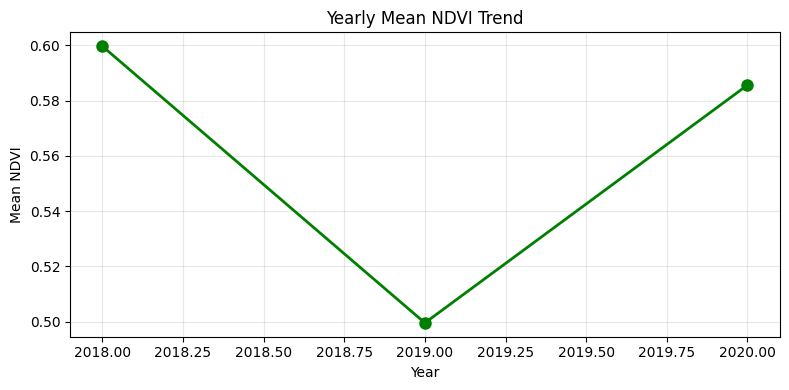

In [18]:

# ============================================================================
# CELL 3: Calculate Mean NDVI
# ============================================================================
print("\n📊 Calculating mean NDVI...")

ndvi_collection = ee.ImageCollection.fromImages(annual_ndvi)

def calculate_mean(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=SCALE,
        maxPixels=1e9
    )
    return image.set('mean_ndvi', mean.get('NDVI'))

NDVI_with_means = ndvi_collection.map(calculate_mean)
means_list = NDVI_with_means.aggregate_array('mean_ndvi').getInfo()
years_list = list(YEARS)

print("\nMean NDVI values:")
for year, mean_val in zip(years_list, means_list):
    print(f"  {year}: {mean_val:.4f}")

# Quick visualization
plt.figure(figsize=(8, 4))
plt.plot(years_list, means_list, marker='o', linewidth=2, 
         markersize=8, color='green')
plt.xlabel('Year')
plt.ylabel('Mean NDVI')
plt.title('Yearly Mean NDVI Trend')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [21]:

# ============================================================================
# CELL 4: Export NDVI Arrays 
# ============================================================================
print("\n📥 Exporting NDVI arrays...")

def export_ndvi_arrays(roi, annual_ndvi, scale=SCALE):
    """Export NDVI with optimized resolution"""
    ndvi_arrays = []
    
    for i, ndvi_img in enumerate(annual_ndvi):
        year = min(YEARS) + i
        print(f"  Exporting {year}...")
        
        try:
            ndvi_array = geemap.ee_to_numpy(
                ndvi_img, region=roi, scale=scale, bands=['NDVI']
            )
        except:
            ndvi_data = ndvi_img.sampleRectangle(region=roi, defaultValue=0)
            ndvi_array = np.array(ndvi_data.get('NDVI').getInfo())
        
        if len(ndvi_array.shape) == 3:
            ndvi_array = ndvi_array.squeeze()
        
        ndvi_arrays.append(ndvi_array)
        print(f"    Shape: {ndvi_array.shape}, Range: [{np.nanmin(ndvi_array):.3f}, {np.nanmax(ndvi_array):.3f}]")
    
    return ndvi_arrays

ndvi_arrays = export_ndvi_arrays(roi, annual_ndvi)
print(f"✓ Exported {len(ndvi_arrays)} arrays")



📥 Exporting NDVI arrays...
  Exporting 2018...
    Shape: (335, 335), Range: [-0.466, 0.890]
  Exporting 2019...
    Shape: (335, 335), Range: [-0.281, 0.828]
  Exporting 2020...
    Shape: (335, 335), Range: [-0.432, 0.874]
✓ Exported 3 arrays


In [22]:

# ============================================================================
# CELL 5: Create Labels
# ============================================================================
print("\n🏷️  Creating degradation labels...")

def create_degradation_labels(ndvi_arrays, threshold=-0.05):
    """Create binary degradation labels"""
    labels = []
    
    for i in range(len(ndvi_arrays) - 1):
        year_current = min(YEARS) + i
        array_current = np.nan_to_num(ndvi_arrays[i], nan=0.0)
        array_next = np.nan_to_num(ndvi_arrays[i + 1], nan=0.0)
        
        ndvi_change = array_next - array_current
        degraded = (ndvi_change < threshold).astype(np.float32)
        
        valid_pixels = (array_current != 0) & (array_next != 0)
        num_degraded = np.sum(degraded[valid_pixels])
        percent = 100 * num_degraded / np.sum(valid_pixels)
        
        print(f"  {year_current}→{year_current+1}: {int(num_degraded):,} degraded pixels ({percent:.1f}%)")
        labels.append(degraded)
    
    return labels

labels = create_degradation_labels(ndvi_arrays)
print(f"✓ Created {len(labels)} label arrays")



🏷️  Creating degradation labels...
  2018→2019: 86,802 degraded pixels (77.4%)
  2019→2020: 3,006 degraded pixels (2.7%)
✓ Created 2 label arrays


In [23]:

# ============================================================================
# CELL 6: Lightweight Dataset (Spatial Sampling)
# ============================================================================
print("\n🎲 Creating dataset with spatial sampling...")

class LightweightNDVIDataset(Dataset):
    """Spatially sampled dataset for reduced memory usage"""
    
    def __init__(self, ndvi_arrays, labels=None, sequence_length=SEQUENCE_LENGTH, 
                 sample_rate=0.1):  # Sample only 10% of pixels
        self.sequence_length = sequence_length
        self.labels = labels
        
        # Stack and normalize
        self.data = np.stack(ndvi_arrays, axis=0)
        self.data = np.nan_to_num(self.data, nan=0.0)
        self.data = np.clip((self.data + 1) / 2, 0, 1)
        
        self.n_years, self.height, self.width = self.data.shape
        print(f"  Data shape: {self.data.shape}")
        
        # Create sequences with spatial sampling
        self.sequences = []
        self.targets = []
        
        # Sample pixels randomly
        total_pixels = self.height * self.width
        n_samples = int(total_pixels * sample_rate)
        
        rng = np.random.RandomState(42)
        sampled_indices = rng.choice(total_pixels, n_samples, replace=False)
        
        for idx in sampled_indices:
            i = idx // self.width
            j = idx % self.width
            
            for t in range(self.n_years - sequence_length):
                seq = self.data[t:t+sequence_length, i, j]
                
                if np.sum(seq) > 0:
                    self.sequences.append(seq)
                    
                    if labels is not None:
                        target = labels[t + sequence_length - 1][i, j]
                        self.targets.append(target)
        
        self.sequences = np.array(self.sequences, dtype=np.float32)
        if labels is not None:
            self.targets = np.array(self.targets, dtype=np.float32)
        
        print(f"✓ Created {len(self.sequences):,} samples")
        if labels is not None:
            num_degraded = np.sum(self.targets)
            print(f"✓ Degraded: {int(num_degraded):,} ({100*num_degraded/len(self.targets):.1f}%)")
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = torch.FloatTensor(self.sequences[idx])
        if self.targets is not None:
            target = torch.FloatTensor([self.targets[idx]])
            return sequence, target
        return sequence

# Create dataset with sampling
dataset = LightweightNDVIDataset(ndvi_arrays, labels, 
                                  sequence_length=SEQUENCE_LENGTH,
                                  sample_rate=0.1)

# Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

print(f"\n📊 Data split:")
print(f"   Training: {len(train_dataset):,}")
print(f"   Validation: {len(val_dataset):,}")

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



🎲 Creating dataset with spatial sampling...
  Data shape: (3, 335, 335)
✓ Created 11,222 samples
✓ Degraded: 283 (2.5%)

📊 Data split:
   Training: 8,977
   Validation: 2,245


In [24]:

# ============================================================================
# CELL 7: Building Model
# ============================================================================
print("\n🧠 Building lightweight model...")

class LightDegradationModel(nn.Module):
    """Compact LSTM model"""
    
    def __init__(self, hidden_size=HIDDEN_SIZE, num_layers=1):
        super(LightDegradationModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        out = self.fc(last_hidden)
        out = self.sigmoid(out)
        return out

model = LightDegradationModel(hidden_size=HIDDEN_SIZE, num_layers=1)
total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model parameters: {total_params:,}")



🧠 Building lightweight model...
✓ Model parameters: 4,513


In [ ]:

# ============================================================================
# CELL 8: Fast Training
# ============================================================================
print("\n🚀 Training model...")

def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=0.001):
    """Efficient training loop"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"  Device: {device}")
    
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        if (epoch + 1) % 5 == 0:
            print(f'  Epoch {epoch+1}/{epochs}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')
    
    print(f"\n✓ Training complete! Best val loss: {best_val_loss:.4f}")
    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train', linewidth=2)
plt.plot(val_losses, label='Validation', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



🚀 Training model...
  Device: cpu
  Epoch 5/20: Train Loss=0.1166, Val Loss=0.1064


In [ ]:

# ============================================================================
# CELL 9: Predict
# ============================================================================
print("\n🔮 Generating predictions...")

def predict_degradation(model, ndvi_arrays, sequence_length=SEQUENCE_LENGTH):
    """Predict degradation map"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model = model.to(device)
    
    recent_data = np.stack(ndvi_arrays[-sequence_length:], axis=0)
    recent_data = np.nan_to_num(recent_data, nan=0.0)
    recent_data = np.clip((recent_data + 1) / 2, 0, 1)
    
    height, width = recent_data.shape[1], recent_data.shape[2]
    degradation_map = np.zeros((height, width))
    
    with torch.no_grad():
        for i in range(height):
            if i % 20 == 0:
                print(f"  Progress: {100*i/height:.0f}%", end='\r')
            for j in range(width):
                sequence = recent_data[:, i, j]
                if np.sum(sequence) > 0:
                    seq_tensor = torch.FloatTensor(sequence).unsqueeze(0).to(device)
                    prediction = model(seq_tensor).cpu().numpy()[0, 0]
                    degradation_map[i, j] = prediction
    
    print("  Progress: 100%")
    return degradation_map

model.load_state_dict(torch.load('best_model.pth'))
degradation_map = predict_degradation(model, ndvi_arrays)
print("✓ Prediction complete!")


In [ ]:

# ============================================================================
# CELL 10: Visualize
# ============================================================================
print("\n🗺️  Creating risk map...")

plt.figure(figsize=(10, 8))
im = plt.imshow(degradation_map, cmap='RdYlGn_r', vmin=0, vmax=1)
plt.colorbar(im, label='Degradation Risk', shrink=0.8)
plt.title('Land Degradation Risk Map', fontsize=14, fontweight='bold')
plt.xlabel('West → East')
plt.ylabel('North → South')

legend_text = """RISK LEVELS:
🟢 Low (0.0-0.3)
🟡 Medium (0.3-0.6)
🔴 High (0.6-1.0)"""

plt.text(0.02, 0.98, legend_text, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.savefig('degradation_risk_map.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
valid = degradation_map[degradation_map > 0]
high = np.sum(valid > 0.6)
medium = np.sum((valid > 0.3) & (valid <= 0.6))
low = np.sum(valid <= 0.3)
total = len(valid)

print("\n📊 RISK DISTRIBUTION:")
print(f"   🔴 High: {high:,} pixels ({100*high/total:.1f}%)")
print(f"   🟡 Medium: {medium:,} pixels ({100*medium/total:.1f}%)")
print(f"   🟢 Low: {low:,} pixels ({100*low/total:.1f}%)")

print("\n" + "="*60)
print("✓ ANALYSIS COMPLETE!")
print("="*60)